### LBM Inference (original)

In [ ]:
import argparse
import logging
import os

import torch
from PIL import Image

from lbm.inference import evaluate, get_model

save_dir = "/code/LBM/examples/inference/ckpts/relighting"
model = get_model(
    f"jasperai/LBM_relighting",
    save_dir=save_dir,
    torch_dtype=torch.bfloat16,
    device="cuda",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 8577.31it/s]
The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
source_image = Image.open("/code/LBM/assets/source_image.jpg").convert("RGB")
num_inference_steps = 1
output_image = evaluate(model, source_image, num_inference_steps)

In [ ]:
output_image

### LBM Inference (level 1)

In [1]:
import logging
import os
from typing import List, Optional

import torch
import yaml
from diffusers import FlowMatchEulerDiscreteScheduler
from huggingface_hub import snapshot_download
from safetensors.torch import load_file

from lbm.models.embedders import (
    ConditionerWrapper,
    LatentsConcatEmbedder,
    LatentsConcatEmbedderConfig,
)
from lbm.models.lbm import LBMConfig, LBMModel
from lbm.models.unets import DiffusersUNet2DCondWrapper
from lbm.models.vae import AutoencoderKLDiffusers, AutoencoderKLDiffusersConfig
from lbm.inference import evaluate


def _get_model_from_config(
    backbone_signature: str = "stabilityai/stable-diffusion-xl-base-1.0",
    vae_num_channels: int = 4,
    unet_input_channels: int = 4,
    timestep_sampling: str = "log_normal",
    selected_timesteps: Optional[List[float]] = None,
    prob: Optional[List[float]] = None,
    conditioning_images_keys: Optional[List[str]] = [],
    conditioning_masks_keys: Optional[List[str]] = [],
    source_key: str = "source_image",
    target_key: str = "source_image_paste",
    bridge_noise_sigma: float = 0.0,
    logit_mean: float = 0.0,
    logit_std: float = 1.0,
    pixel_loss_type: str = "lpips",
    latent_loss_type: str = "l2",
    latent_loss_weight: float = 1.0,
    pixel_loss_weight: float = 0.0,
    torch_dtype: torch.dtype = torch.bfloat16,
    **kwargs,
):

    conditioners = []

    denoiser = DiffusersUNet2DCondWrapper(
        in_channels=unet_input_channels,  # Add downsampled_image
        out_channels=vae_num_channels,
        center_input_sample=False,
        flip_sin_to_cos=True,
        freq_shift=0,
        down_block_types=[
            "DownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
        ],
        mid_block_type="UNetMidBlock2DCrossAttn",
        up_block_types=["CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "UpBlock2D"],
        only_cross_attention=False,
        block_out_channels=[320, 640, 1280],
        layers_per_block=2,
        downsample_padding=1,
        mid_block_scale_factor=1,
        dropout=0.0,
        act_fn="silu",
        norm_num_groups=32,
        norm_eps=1e-05,
        cross_attention_dim=[320, 640, 1280],
        transformer_layers_per_block=[1, 2, 10],
        reverse_transformer_layers_per_block=None,
        encoder_hid_dim=None,
        encoder_hid_dim_type=None,
        attention_head_dim=[5, 10, 20],
        num_attention_heads=None,
        dual_cross_attention=False,
        use_linear_projection=True,
        class_embed_type=None,
        addition_embed_type=None,
        addition_time_embed_dim=None,
        num_class_embeds=None,
        upcast_attention=None,
        resnet_time_scale_shift="default",
        resnet_skip_time_act=False,
        resnet_out_scale_factor=1.0,
        time_embedding_type="positional",
        time_embedding_dim=None,
        time_embedding_act_fn=None,
        timestep_post_act=None,
        time_cond_proj_dim=None,
        conv_in_kernel=3,
        conv_out_kernel=3,
        projection_class_embeddings_input_dim=None,
        attention_type="default",
        class_embeddings_concat=False,
        mid_block_only_cross_attention=None,
        cross_attention_norm=None,
        addition_embed_type_num_heads=64,
    ).to(torch_dtype)

    # NOT USED IN RELIGHTING
    # print(
    #     conditioning_images_keys != [] or conditioning_masks_keys != [],
    #     "conditioning_images_keys != [] or conditioning_masks_keys != []",
    # )
    # if conditioning_images_keys != [] or conditioning_masks_keys != []:

    #     latents_concat_embedder_config = LatentsConcatEmbedderConfig(
    #         image_keys=conditioning_images_keys,
    #         mask_keys=conditioning_masks_keys,
    #     )
    #     latent_concat_embedder = LatentsConcatEmbedder(latents_concat_embedder_config)
    #     latent_concat_embedder.freeze()
    #     conditioners.append(latent_concat_embedder)

    # Wrap conditioners and set to device
    conditioner = ConditionerWrapper(
        conditioners=conditioners,
    )

    ## VAE ##
    # Get VAE model
    vae_config = AutoencoderKLDiffusersConfig(
        version=backbone_signature,
        subfolder="vae",
        tiling_size=(128, 128),
    )
    vae = AutoencoderKLDiffusers(vae_config).to(torch_dtype)
    vae.freeze()
    vae.to(torch_dtype)

    ## Diffusion Model ##
    # Get diffusion model
    config = LBMConfig(
        source_key=source_key,
        target_key=target_key,
        latent_loss_weight=latent_loss_weight,
        latent_loss_type=latent_loss_type,
        pixel_loss_type=pixel_loss_type,
        pixel_loss_weight=pixel_loss_weight,
        timestep_sampling=timestep_sampling,
        logit_mean=logit_mean,
        logit_std=logit_std,
        selected_timesteps=selected_timesteps,
        prob=prob,
        bridge_noise_sigma=bridge_noise_sigma,
    )

    sampling_noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
        backbone_signature,
        subfolder="scheduler",
    )

    model = LBMModel(
        config,
        denoiser=denoiser,
        sampling_noise_scheduler=sampling_noise_scheduler,
        vae=vae,
        conditioner=conditioner,
    ).to(torch_dtype)

    return model


model_dir = "/code/LBM/examples/inference/ckpts/relighting"
torch_dtype = torch.bfloat16
device = "cuda"

config = {
    "backbone_signature": "stabilityai/stable-diffusion-xl-base-1.0",
    "vae_num_channels": 4,
    "unet_input_channels": 4,
    "timestep_sampling": "custom_timesteps",
    "selected_timesteps": [250, 500, 750, 1000],
    "prob": [0.25, 0.25, 0.25, 0.25],
    "conditioning_images_keys": [],
    "conditioning_masks_keys": [],
    "source_key": "source_image",
    "target_key": "source_image_paste",
    "bridge_noise_sigma": 0.005,
}
model = _get_model_from_config(**config, torch_dtype=torch_dtype)

sd = load_file(os.path.join(model_dir, "model.safetensors"))
model.load_state_dict(sd, strict=True)

model.to(device).to(torch_dtype)

model = model.eval()
None

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
from PIL import Image

source_image = Image.open("/code/LBM/assets/source_image.jpg").convert("RGB")
num_inference_steps = 1
output_image = evaluate(model, source_image, num_inference_steps)
output_image

In [5]:
import numpy as np

np.array(source_image).shape

(896, 1152, 3)

### LBM Inference (level 2)

In [1]:
from typing import Any, Dict, List, Optional, Tuple, Union
import os
from typing import List, Optional

import torch
from safetensors.torch import load_file
from lbm.models.lbm import LBMConfig
from lbm.models.unets import DiffusersUNet2DCondWrapper
from lbm.models.vae import AutoencoderKLDiffusersConfig


import lpips
import numpy as np
import torch
import torch.nn as nn
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from tqdm import tqdm

from lbm.models.base.base_model import BaseModel
from lbm.models.embedders import ConditionerWrapper
from lbm.models.unets import DiffusersUNet2DCondWrapper, DiffusersUNet2DWrapper
from diffusers.models import AutoencoderKL
from lbm.models.utils import Tiler, pad


class AutoencoderKLDiffusers(BaseModel):
    """This is the VAE class used to work with latent models

    Args:

        config (AutoencoderKLDiffusersConfig): The config class which defines all the required parameters.
    """

    def __init__(self, config: AutoencoderKLDiffusersConfig):
        BaseModel.__init__(self, config)
        self.config = config
        self.vae_model = AutoencoderKL.from_pretrained(
            config.version,
            subfolder=config.subfolder,
            revision=config.revision,
        )
        self.tiling_size = config.tiling_size
        self.tiling_overlap = config.tiling_overlap

        # get downsampling factor
        self._get_properties()

    @torch.no_grad()
    def _get_properties(self):
        self.has_shift_factor = (
            hasattr(self.vae_model.config, "shift_factor")
            and self.vae_model.config.shift_factor is not None
        )
        self.shift_factor = (
            self.vae_model.config.shift_factor if self.has_shift_factor else 0
        )

        # set latent channels
        self.latent_channels = self.vae_model.config.latent_channels
        self.has_latents_mean = (
            hasattr(self.vae_model.config, "latents_mean")
            and self.vae_model.config.latents_mean is not None
        )
        self.has_latents_std = (
            hasattr(self.vae_model.config, "latents_std")
            and self.vae_model.config.latents_std is not None
        )
        self.latents_mean = self.vae_model.config.latents_mean
        self.latents_std = self.vae_model.config.latents_std

        x = torch.randn(1, self.vae_model.config.in_channels, 32, 32)
        z = self.encode(x)

        # set downsampling factor
        self.downsampling_factor = int(x.shape[2] / z.shape[2])

    def encode(self, x: torch.tensor, batch_size: int = 8):
        latents = []
        for i in range(0, x.shape[0], batch_size):
            latents.append(
                self.vae_model.encode(x[i : i + batch_size]).latent_dist.sample()
            )
        latents = torch.cat(latents, dim=0)
        latents = (latents - self.shift_factor) * self.vae_model.config.scaling_factor

        return latents

    def decode(self, z: torch.tensor):

        if self.has_latents_mean and self.has_latents_std:
            latents_mean = (
                torch.tensor(self.latents_mean)
                .view(1, self.latent_channels, 1, 1)
                .to(z.device, z.dtype)
            )
            latents_std = (
                torch.tensor(self.latents_std)
                .view(1, self.latent_channels, 1, 1)
                .to(z.device, z.dtype)
            )
            z = z * latents_std / self.vae_model.config.scaling_factor + latents_mean
        else:
            z = z / self.vae_model.config.scaling_factor + self.shift_factor

        use_tiling = (
            z.shape[2] > self.tiling_size[0] or z.shape[3] > self.tiling_size[1]
        )

        if use_tiling:
            samples = []
            for i in range(z.shape[0]):

                z_i = z[i].unsqueeze(0)

                tiler = Tiler()
                tiles = tiler.get_tiles(
                    input=z_i,
                    tile_size=self.tiling_size,
                    overlap_size=self.tiling_overlap,
                    scale=self.downsampling_factor,
                    out_channels=3,
                )

                for i, tile_row in enumerate(tiles):
                    for j, tile in enumerate(tile_row):
                        tile_shape = tile.shape
                        # pad tile to inference size if tile is smaller than inference size
                        tile = pad(
                            tile,
                            base_h=self.tiling_size[0],
                            base_w=self.tiling_size[1],
                        )
                        tile_decoded = self.vae_model.decode(tile).sample
                        tiles[i][j] = (
                            tile_decoded[
                                0,
                                :,
                                : int(tile_shape[2] * self.downsampling_factor),
                                : int(tile_shape[3] * self.downsampling_factor),
                            ]
                            .cpu()
                            .unsqueeze(0)
                        )

                # merge tiles
                samples.append(tiler.merge_tiles(tiles=tiles))

            samples = torch.cat(samples, dim=0)

        else:
            samples = self.vae_model.decode(z).sample

        return samples


class LBMModel(BaseModel):
    """This is the LBM class which defines the model.

    Args:

        config (LBMConfig):
            Configuration for the model

        denoiser (Union[DiffusersUNet2DWrapper, DiffusersTransformer2DWrapper]):
            Denoiser to use for the diffusion model. Defaults to None

        training_noise_scheduler (EulerDiscreteScheduler):
            Noise scheduler to use for training. Defaults to None

        sampling_noise_scheduler (EulerDiscreteScheduler):
            Noise scheduler to use for sampling. Defaults to None

        vae (AutoencoderKLDiffusers):
            VAE to use for the diffusion model. Defaults to None

        conditioner (ConditionerWrapper):
            Conditioner to use for the diffusion model. Defaults to None
    """

    @classmethod
    def load_from_config(cls, config: LBMConfig):
        return cls(config=config)

    def __init__(
        self,
        config: LBMConfig,
        denoiser: Union[
            DiffusersUNet2DWrapper,
            DiffusersUNet2DCondWrapper,
        ] = None,
        training_noise_scheduler: FlowMatchEulerDiscreteScheduler = None,
        sampling_noise_scheduler: FlowMatchEulerDiscreteScheduler = None,
        vae: AutoencoderKLDiffusers = None,
        conditioner: ConditionerWrapper = None,
    ):
        BaseModel.__init__(self, config)

        self.vae = vae
        self.denoiser = denoiser
        self.conditioner = conditioner
        self.sampling_noise_scheduler = sampling_noise_scheduler
        self.training_noise_scheduler = training_noise_scheduler
        self.timestep_sampling = config.timestep_sampling
        self.latent_loss_type = config.latent_loss_type
        self.latent_loss_weight = config.latent_loss_weight
        self.pixel_loss_type = config.pixel_loss_type
        self.pixel_loss_max_size = config.pixel_loss_max_size
        self.pixel_loss_weight = config.pixel_loss_weight
        self.logit_mean = config.logit_mean
        self.logit_std = config.logit_std
        self.prob = config.prob
        self.selected_timesteps = config.selected_timesteps
        self.source_key = config.source_key
        self.target_key = config.target_key
        self.mask_key = config.mask_key
        self.bridge_noise_sigma = config.bridge_noise_sigma

        self.num_iterations = nn.Parameter(
            torch.tensor(0, dtype=torch.float32), requires_grad=False
        )
        if self.pixel_loss_type == "lpips" and self.pixel_loss_weight > 0:
            self.lpips_loss = lpips.LPIPS(net="vgg")

        else:
            self.lpips_loss = None

    def on_fit_start(self, device: torch.device | None = None, *args, **kwargs):
        """Called when the training starts"""
        super().on_fit_start(device=device, *args, **kwargs)
        if self.vae is not None:
            self.vae.on_fit_start(device=device, *args, **kwargs)
        if self.conditioner is not None:
            self.conditioner.on_fit_start(device=device, *args, **kwargs)

    def forward(self, batch: Dict[str, Any], step=0, batch_idx=0, *args, **kwargs):

        self.num_iterations += 1

        # Get inputs/latents
        if self.vae is not None:
            vae_inputs = batch[self.target_key]
            z = self.vae.encode(vae_inputs)
            downsampling_factor = self.vae.downsampling_factor
        else:
            z = batch[self.target_key]
            downsampling_factor = 1

        if self.mask_key in batch:
            valid_mask = batch[self.mask_key].bool()[:, 0, :, :].unsqueeze(1)
            invalid_mask = ~valid_mask
            valid_mask_for_latent = ~torch.max_pool2d(
                invalid_mask.float(),
                downsampling_factor,
                downsampling_factor,
            ).bool()
            valid_mask_for_latent = valid_mask_for_latent.repeat((1, z.shape[1], 1, 1))

        else:
            valid_mask = torch.ones_like(batch[self.target_key]).bool()
            valid_mask_for_latent = torch.ones_like(z).bool()

        source_image = batch[self.source_key]
        source_image = torch.nn.functional.interpolate(
            source_image,
            size=batch[self.target_key].shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).to(z.dtype)
        if self.vae is not None:
            z_source = self.vae.encode(source_image)

        else:
            z_source = source_image

        # Get conditionings
        conditioning = self._get_conditioning(batch, *args, **kwargs)

        # Sample a timestep
        timestep = self._timestep_sampling(n_samples=z.shape[0], device=z.device)
        sigmas = None

        # Create interpolant
        sigmas = self._get_sigmas(
            self.training_noise_scheduler, timestep, n_dim=4, device=z.device
        )
        noisy_sample = (
            sigmas * z_source
            + (1.0 - sigmas) * z
            + self.bridge_noise_sigma
            * (sigmas * (1.0 - sigmas)) ** 0.5
            * torch.randn_like(z)
        )

        for i, t in enumerate(timestep):
            if t.item() == self.training_noise_scheduler.timesteps[0]:
                noisy_sample[i] = z_source[i]

        # Predict noise level using denoiser
        prediction = self.denoiser(
            sample=noisy_sample,
            timestep=timestep,
            conditioning=conditioning,
            *args,
            **kwargs,
        )

        target = z_source - z
        denoised_sample = noisy_sample - prediction * sigmas
        target_pixels = batch[self.target_key]

        # Compute loss
        if self.latent_loss_weight > 0:
            loss = self.latent_loss(prediction, target.detach(), valid_mask_for_latent)
            latent_recon_loss = loss.mean()

        else:
            loss = torch.zeros(z.shape[0], device=z.device)
            latent_recon_loss = torch.zeros_like(loss)

        if self.pixel_loss_weight > 0:
            denoised_sample = self._predicted_x_0(
                model_output=prediction,
                sample=noisy_sample,
                sigmas=sigmas,
            )
            pixel_loss = self.pixel_loss(
                denoised_sample, target_pixels.detach(), valid_mask
            )
            loss += self.pixel_loss_weight * pixel_loss

        else:
            pixel_loss = torch.zeros_like(latent_recon_loss)

        return {
            "loss": loss.mean(),
            "latent_recon_loss": latent_recon_loss,
            "pixel_recon_loss": pixel_loss.mean(),
            "predicted_hr": denoised_sample,
            "noisy_sample": noisy_sample,
        }

    def latent_loss(self, prediction, model_input, valid_latent_mask):
        if self.latent_loss_type == "l2":
            return torch.mean(
                (
                    (prediction * valid_latent_mask - model_input * valid_latent_mask)
                    ** 2
                ).reshape(model_input.shape[0], -1),
                1,
            )
        elif self.latent_loss_type == "l1":
            return torch.mean(
                torch.abs(
                    prediction * valid_latent_mask - model_input * valid_latent_mask
                ).reshape(model_input.shape[0], -1),
                1,
            )
        else:
            raise NotImplementedError(
                f"Loss type {self.latent_loss_type} not implemented"
            )

    def pixel_loss(self, prediction, model_input, valid_mask):

        latent_crop = self.pixel_loss_max_size // self.vae.downsampling_factor
        input_crop = self.pixel_loss_max_size

        crop_h = max((prediction.shape[2] - latent_crop), 0)
        crop_w = max((prediction.shape[3] - latent_crop), 0)

        input_crop_h = max((model_input.shape[2] - self.pixel_loss_max_size), 0)
        input_crop_w = max((model_input.shape[3] - self.pixel_loss_max_size), 0)

        # image random cropping
        if crop_h == 0:
            offset_h = 0
        else:
            offset_h = torch.randint(0, crop_h, (1,)).item()

        if crop_w == 0:
            offset_w = 0
        else:
            offset_w = torch.randint(0, crop_w, (1,)).item()
        input_offset_h = offset_h * self.vae.downsampling_factor
        input_offset_w = offset_w * self.vae.downsampling_factor

        prediction = prediction[
            :,
            :,
            crop_h
            - offset_h : min(crop_h - offset_h + latent_crop, prediction.shape[2]),
            crop_w
            - offset_w : min(crop_w - offset_w + latent_crop, prediction.shape[3]),
        ]

        model_input = model_input[
            :,
            :,
            input_crop_h
            - input_offset_h : min(
                input_crop_h - input_offset_h + input_crop, model_input.shape[2]
            ),
            input_crop_w
            - input_offset_w : min(
                input_crop_w - input_offset_w + input_crop, model_input.shape[3]
            ),
        ]

        valid_mask = valid_mask[
            :,
            :,
            input_crop_h
            - input_offset_h : min(
                input_crop_h - input_offset_h + input_crop, valid_mask.shape[2]
            ),
            input_crop_w
            - input_offset_w : min(
                input_crop_w - input_offset_w + input_crop, valid_mask.shape[3]
            ),
        ]

        decoded_prediction = self.vae.decode(prediction).clamp(-1, 1)

        if self.pixel_loss_type == "l2":
            return torch.mean(
                (
                    (decoded_prediction * valid_mask - model_input * valid_mask) ** 2
                ).reshape(model_input.shape[0], -1),
                1,
            )

        elif self.pixel_loss_type == "l1":
            return torch.mean(
                torch.abs(
                    decoded_prediction * valid_mask - model_input * valid_mask
                ).reshape(model_input.shape[0], -1),
                1,
            )

        elif self.pixel_loss_type == "lpips":
            return self.lpips_loss(
                decoded_prediction * valid_mask, model_input * valid_mask
            ).mean()

    def _get_conditioning(
        self,
        batch: Dict[str, Any],
        ucg_keys: List[str] = None,
        set_ucg_rate_zero=False,
        *args,
        **kwargs,
    ):
        """
        Get the conditionings
        """
        if self.conditioner is not None:
            return self.conditioner(
                batch,
                ucg_keys=ucg_keys,
                set_ucg_rate_zero=set_ucg_rate_zero,
                vae=self.vae,
                *args,
                **kwargs,
            )
        else:
            return None

    def _timestep_sampling(self, n_samples=1, device="cpu"):
        if self.timestep_sampling == "uniform":
            idx = torch.randint(
                0,
                self.training_noise_scheduler.config.num_train_timesteps,
                (n_samples,),
                device="cpu",
            )
            return self.training_noise_scheduler.timesteps[idx].to(device=device)

        elif self.timestep_sampling == "log_normal":
            u = torch.normal(
                mean=self.logit_mean,
                std=self.logit_std,
                size=(n_samples,),
                device="cpu",
            )
            u = torch.nn.functional.sigmoid(u)
            indices = (
                u * self.training_noise_scheduler.config.num_train_timesteps
            ).long()
            return self.training_noise_scheduler.timesteps[indices].to(device=device)

        elif self.timestep_sampling == "custom_timesteps":
            idx = np.random.choice(len(self.selected_timesteps), n_samples, p=self.prob)

            return torch.tensor(
                self.selected_timesteps, device=device, dtype=torch.long
            )[idx]

    def _predicted_x_0(
        self,
        model_output,
        sample,
        sigmas=None,
    ):
        """
        Predict x_0, the orinal denoised sample, using the model output and the timesteps depending on the prediction type.
        """
        pred_x_0 = sample - model_output * sigmas
        return pred_x_0

    def _get_sigmas(
        self, scheduler, timesteps, n_dim=4, dtype=torch.float32, device="cpu"
    ):
        sigmas = scheduler.sigmas.to(device=device, dtype=dtype)
        schedule_timesteps = scheduler.timesteps.to(device)
        timesteps = timesteps.to(device)
        step_indices = [(schedule_timesteps == t).nonzero().item() for t in timesteps]

        sigma = sigmas[step_indices].flatten()
        while len(sigma.shape) < n_dim:
            sigma = sigma.unsqueeze(-1)
        return sigma

    @torch.no_grad()
    def sample(
        self,
        z: torch.Tensor,
        num_steps: int = 20,
        conditioner_inputs: Optional[Dict[str, Any]] = None,
        max_samples: Optional[int] = None,
        verbose: bool = False,
    ):
        self.sampling_noise_scheduler.set_timesteps(
            sigmas=np.linspace(1, 1 / num_steps, num_steps)
        )

        sample = z

        # Get conditioning
        conditioning = self._get_conditioning(
            conditioner_inputs, set_ucg_rate_zero=True, device=z.device
        )

        # If max_samples parameter is provided, limit the number of samples
        if max_samples is not None:
            sample = sample[:max_samples]

        if conditioning:
            conditioning["cond"] = {
                k: v[:max_samples] for k, v in conditioning["cond"].items()
            }

        for i, t in tqdm(
            enumerate(self.sampling_noise_scheduler.timesteps), disable=not verbose
        ):
            if hasattr(self.sampling_noise_scheduler, "scale_model_input"):
                denoiser_input = self.sampling_noise_scheduler.scale_model_input(
                    sample, t
                )

            else:
                denoiser_input = sample

            # Predict noise level using denoiser using conditionings
            pred = self.denoiser(
                sample=denoiser_input,
                timestep=t.to(z.device).repeat(denoiser_input.shape[0]),
                conditioning=conditioning,
            )

            # Make one step on the reverse diffusion process
            sample = self.sampling_noise_scheduler.step(
                pred, t, sample, return_dict=False
            )[0]
            if i < len(self.sampling_noise_scheduler.timesteps) - 1:
                timestep = (
                    self.sampling_noise_scheduler.timesteps[i + 1]
                    .to(z.device)
                    .repeat(sample.shape[0])
                )
                sigmas = self._get_sigmas(
                    self.sampling_noise_scheduler, timestep, n_dim=4, device=z.device
                )
                sample = sample + self.bridge_noise_sigma * (
                    sigmas * (1.0 - sigmas)
                ) ** 0.5 * torch.randn_like(sample)
                sample = sample.to(z.dtype)

        if self.vae is not None:
            decoded_sample = self.vae.decode(sample)

        else:
            decoded_sample = sample

        return decoded_sample

    def log_samples(
        self,
        batch: Dict[str, Any],
        input_shape: Optional[Tuple[int, int, int]] = None,
        max_samples: Optional[int] = None,
        num_steps: Union[int, List[int]] = 20,
    ):
        if isinstance(num_steps, int):
            num_steps = [num_steps]

        logs = {}

        N = max_samples if max_samples is not None else len(batch[self.source_key])

        batch = {k: v[:N] for k, v in batch.items()}

        # infer input shape based on VAE configuration if not passed
        if input_shape is None:
            if self.vae is not None:
                # get input pixel size of the vae
                input_shape = batch[self.target_key].shape[2:]
                # rescale to latent size
                input_shape = (
                    self.vae.latent_channels,
                    input_shape[0] // self.vae.downsampling_factor,
                    input_shape[1] // self.vae.downsampling_factor,
                )
            else:
                raise ValueError(
                    "input_shape must be passed when no VAE is used in the model"
                )

        for num_step in num_steps:
            source_image = batch[self.source_key]
            source_image = torch.nn.functional.interpolate(
                source_image,
                size=batch[self.target_key].shape[2:],
                mode="bilinear",
                align_corners=False,
            ).to(dtype=self.dtype)
            if self.vae is not None:
                z = self.vae.encode(source_image)

            else:
                z = source_image

            with torch.autocast(dtype=self.dtype, device_type="cuda"):
                logs[f"samples_{num_step}_steps"] = self.sample(
                    z,
                    num_steps=num_step,
                    conditioner_inputs=batch,
                    max_samples=N,
                )

        return logs


def _get_model_from_config(
    backbone_signature: str = "stabilityai/stable-diffusion-xl-base-1.0",
    vae_num_channels: int = 4,
    unet_input_channels: int = 4,
    timestep_sampling: str = "log_normal",
    selected_timesteps: Optional[List[float]] = None,
    prob: Optional[List[float]] = None,
    conditioning_images_keys: Optional[List[str]] = [],
    conditioning_masks_keys: Optional[List[str]] = [],
    source_key: str = "source_image",
    target_key: str = "source_image_paste",
    bridge_noise_sigma: float = 0.0,
    logit_mean: float = 0.0,
    logit_std: float = 1.0,
    pixel_loss_type: str = "lpips",
    latent_loss_type: str = "l2",
    latent_loss_weight: float = 1.0,
    pixel_loss_weight: float = 0.0,
    torch_dtype: torch.dtype = torch.bfloat16,
    **kwargs,
):

    conditioners = []

    denoiser = DiffusersUNet2DCondWrapper(
        in_channels=unet_input_channels,  # Add downsampled_image
        out_channels=vae_num_channels,
        center_input_sample=False,
        flip_sin_to_cos=True,
        freq_shift=0,
        down_block_types=[
            "DownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
        ],
        mid_block_type="UNetMidBlock2DCrossAttn",
        up_block_types=["CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "UpBlock2D"],
        only_cross_attention=False,
        block_out_channels=[320, 640, 1280],
        layers_per_block=2,
        downsample_padding=1,
        mid_block_scale_factor=1,
        dropout=0.0,
        act_fn="silu",
        norm_num_groups=32,
        norm_eps=1e-05,
        cross_attention_dim=[320, 640, 1280],
        transformer_layers_per_block=[1, 2, 10],
        reverse_transformer_layers_per_block=None,
        encoder_hid_dim=None,
        encoder_hid_dim_type=None,
        attention_head_dim=[5, 10, 20],
        num_attention_heads=None,
        dual_cross_attention=False,
        use_linear_projection=True,
        class_embed_type=None,
        addition_embed_type=None,
        addition_time_embed_dim=None,
        num_class_embeds=None,
        upcast_attention=None,
        resnet_time_scale_shift="default",
        resnet_skip_time_act=False,
        resnet_out_scale_factor=1.0,
        time_embedding_type="positional",
        time_embedding_dim=None,
        time_embedding_act_fn=None,
        timestep_post_act=None,
        time_cond_proj_dim=None,
        conv_in_kernel=3,
        conv_out_kernel=3,
        projection_class_embeddings_input_dim=None,
        attention_type="default",
        class_embeddings_concat=False,
        mid_block_only_cross_attention=None,
        cross_attention_norm=None,
        addition_embed_type_num_heads=64,
    ).to(torch_dtype)

    # NOT USED IN RELIGHTING
    # print(
    #     conditioning_images_keys != [] or conditioning_masks_keys != [],
    #     "conditioning_images_keys != [] or conditioning_masks_keys != []",
    # )
    # if conditioning_images_keys != [] or conditioning_masks_keys != []:

    #     latents_concat_embedder_config = LatentsConcatEmbedderConfig(
    #         image_keys=conditioning_images_keys,
    #         mask_keys=conditioning_masks_keys,
    #     )
    #     latent_concat_embedder = LatentsConcatEmbedder(latents_concat_embedder_config)
    #     latent_concat_embedder.freeze()
    #     conditioners.append(latent_concat_embedder)

    # Wrap conditioners and set to device
    conditioner = ConditionerWrapper(
        conditioners=conditioners,
    )

    ## VAE ##
    # Get VAE model
    vae_config = AutoencoderKLDiffusersConfig(
        version=backbone_signature,
        subfolder="vae",
        tiling_size=(128, 128),
    )
    vae = AutoencoderKLDiffusers(vae_config).to(torch_dtype)
    vae.freeze()
    vae.to(torch_dtype)

    ## Diffusion Model ##
    # Get diffusion model
    config = LBMConfig(
        source_key=source_key,
        target_key=target_key,
        latent_loss_weight=latent_loss_weight,
        latent_loss_type=latent_loss_type,
        pixel_loss_type=pixel_loss_type,
        pixel_loss_weight=pixel_loss_weight,
        timestep_sampling=timestep_sampling,
        logit_mean=logit_mean,
        logit_std=logit_std,
        selected_timesteps=selected_timesteps,
        prob=prob,
        bridge_noise_sigma=bridge_noise_sigma,
    )

    sampling_noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
        backbone_signature,
        subfolder="scheduler",
    )

    model = LBMModel(
        config,
        denoiser=denoiser,
        sampling_noise_scheduler=sampling_noise_scheduler,
        vae=vae,
        conditioner=conditioner,
    ).to(torch_dtype)

    return model


model_dir = "/code/LBM/examples/inference/ckpts/relighting"
torch_dtype = torch.bfloat16
device = "cuda"

config = {
    "backbone_signature": "stabilityai/stable-diffusion-xl-base-1.0",
    "vae_num_channels": 4,
    "unet_input_channels": 4,
    "timestep_sampling": "custom_timesteps",
    "selected_timesteps": [250, 500, 750, 1000],
    "prob": [0.25, 0.25, 0.25, 0.25],
    "conditioning_images_keys": [],
    "conditioning_masks_keys": [],
    "source_key": "source_image",
    "target_key": "source_image_paste",
    "bridge_noise_sigma": 0.005,
}
model = _get_model_from_config(**config, torch_dtype=torch_dtype)

sd = load_file(os.path.join(model_dir, "model.safetensors"))
model.load_state_dict(sd, strict=True)

model.to(device).to(torch_dtype)

model = model.eval()
None

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


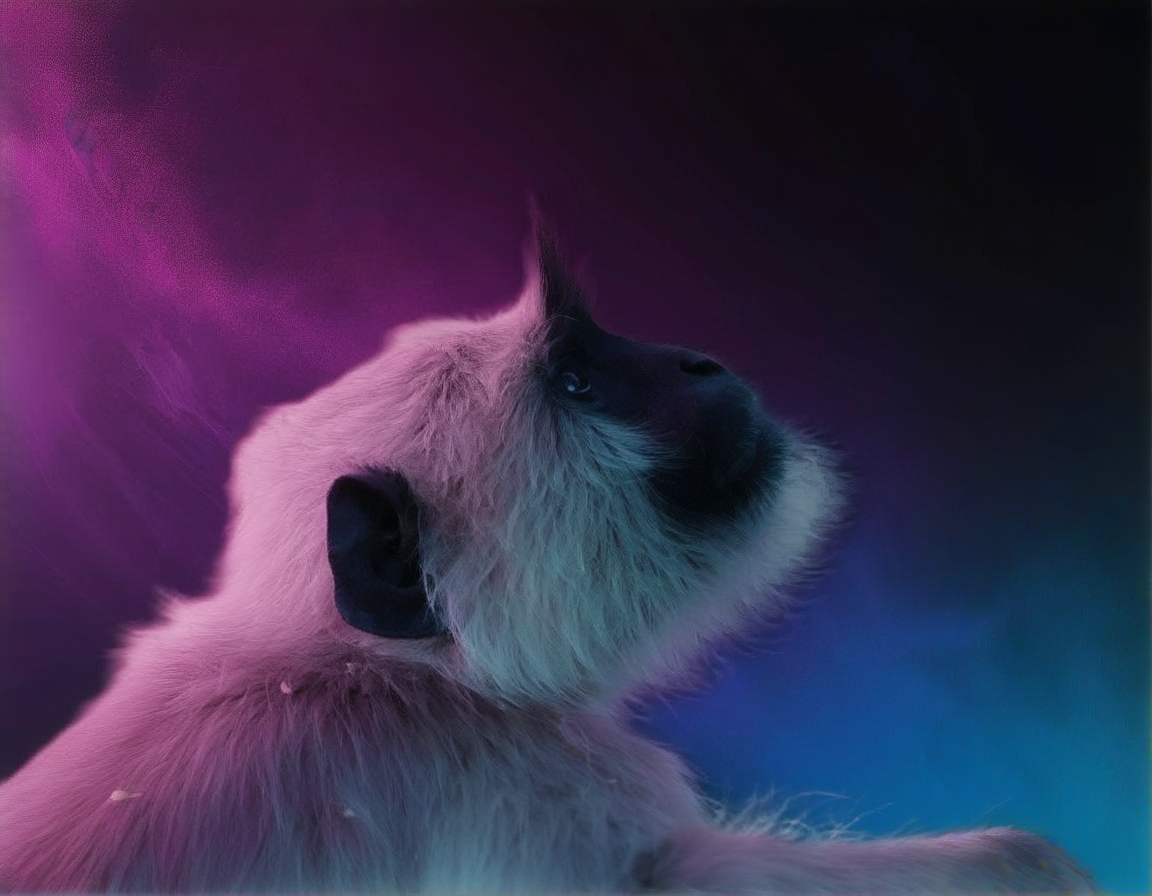

In [2]:
from PIL import Image


import PIL
import torch
from torchvision.transforms import ToPILImage, ToTensor

from lbm.models.lbm import LBMModel


ASPECT_RATIOS = {
    str(512 / 2048): (512, 2048),
    str(1024 / 1024): (1024, 1024),
    str(2048 / 512): (2048, 512),
    str(896 / 1152): (896, 1152),
    str(1152 / 896): (1152, 896),
    str(512 / 1920): (512, 1920),
    str(640 / 1536): (640, 1536),
    str(768 / 1280): (768, 1280),
    str(1280 / 768): (1280, 768),
    str(1536 / 640): (1536, 640),
    str(1920 / 512): (1920, 512),
}


@torch.no_grad()
def evaluate(
    model: LBMModel,
    source_image: PIL.Image.Image,
    num_sampling_steps: int = 1,
):
    """
    Evaluate the model on an image coming from the source distribution and generate a new image from the target distribution.

    Args:
        model (LBMModel): The model to evaluate.
        source_image (PIL.Image.Image): The source image to evaluate the model on.
        num_sampling_steps (int): The number of sampling steps to use for the model.

    Returns:
        PIL.Image.Image: The generated image.
    """

    ori_h_bg, ori_w_bg = source_image.size
    ar_bg = ori_h_bg / ori_w_bg
    closest_ar_bg = min(ASPECT_RATIOS, key=lambda x: abs(float(x) - ar_bg))
    source_dimensions = ASPECT_RATIOS[closest_ar_bg]

    source_image = source_image.resize(source_dimensions)

    img_pasted_tensor = ToTensor()(source_image).unsqueeze(0) * 2 - 1
    batch = {
        "source_image": img_pasted_tensor.cuda().to(torch.bfloat16),
    }

    z_source = model.vae.encode(batch[model.source_key])

    output_image = model.sample(
        z=z_source,
        num_steps=num_sampling_steps,
        conditioner_inputs=batch,
        max_samples=1,
    ).clamp(-1, 1)

    output_image = (output_image[0].float().cpu() + 1) / 2
    output_image = ToPILImage()(output_image)
    output_image.resize((ori_h_bg, ori_w_bg))

    return output_image


source_image = Image.open("/code/LBM/assets/source_image.jpg").convert("RGB")
num_inference_steps = 1
output_image = evaluate(model, source_image, num_inference_steps)
output_image